##### Module Imports

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

##### Load Data & Initial Visualization

In [5]:
df = pd.read_excel('../data_sample/data.xlsx').iloc[:, :-1]
df

,index,track_name,artist_name,top_artist,artist_popularity,followers,album_name,format,duration_s,release_date,...,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch
0,0,PIToRRO DE COCO,Bad Bunny,Bad Bunny,100,94364002,PIToRRO DE COCO,single,206627,2024-12-26,...,2024,98,67,64,-5,12,54,207,25,3
1,1,Terciopelo,Natos y Waor,Natos y Waor,65,859707,Terciopelo,single,133902,2017-03-17,...,2017,92,75,45,-6,14,31,134,34,44
2,2,Un Plan,"Dímelo Flow, Zion & Lennox, Beéle, Jerry Di",Dímelo Flow,70,573351,Always Dream,album,204146,2022-06-09,...,2022,172,82,77,-4,9,59,204,14,7
3,3,PASAJERO,Mora,Mora,81,7154775,ESTRELLA,album,149538,2023-08-28,...,2023,130,67,75,-6,8,34,150,48,4
4,4,Shooters,"Israel B, LOWLIGHT",Israel B,55,82608,Shooters,single,12975,2020-10-29,...,2020,174,45,60,-12,37,15,130,24,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6450,6563,Pelé,"KG970, Elpatron970",KG970,54,187696,Pelé,single,162206,2022-06-17,...,2022,145,69,74,-7,13,76,162,54,19
6451,6564,El Bolero,"Yami Safdie, Milo j",Yami Safdie,72,504681,Dije Que No Me Iba a Enamorar,album,206146,2022-11-16,...,2022,115,30,80,-10,13,70,206,72,4
6452,6565,Primaveras en Diciembre,"Nachodowntempo, Sharif",Nachodowntempo,24,2006,Zaragozatools,album,203213,2016-05-27,...,2016,85,86,64,-5,34,32,203,42,13
6453,6566,VIRGENSITA,"Elio Toffana, Cruz Cafuné",Elio Toffana,45,41249,SHOCK WAVE,album,210733,2022-12-15,...,2022,154,68,78,-7,12,60,211,18,15


<Axes: xlabel='popularity', ylabel='Count'>

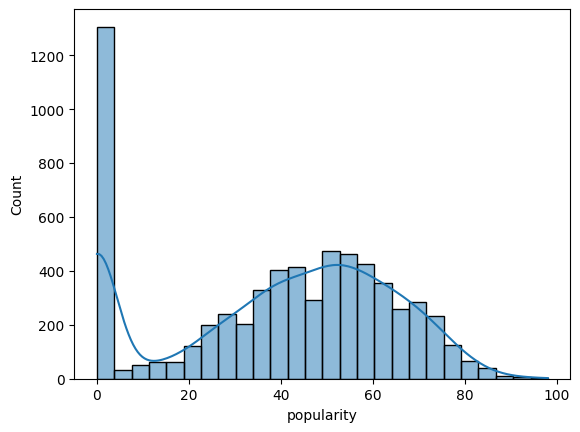

In [3]:
sns.histplot(x= "popularity", data = df, kde = True)

In [6]:
# Convert binary/categorical fields to numeric
for col in ["explicit", "colab", "format"]:
    df[col] = df[col].astype(str).str.lower().map({"true": 1, "false": 0, "album": 0, "single": 1})

# Process 'top genre'
top_genres = df["top genre"].value_counts().head(5).index
df["top_genre_grouped"] = df["top genre"].apply(lambda x: x if x in top_genres else "others")
df = pd.get_dummies(df, columns=["top_genre_grouped"], drop_first=True)

# Drop unnecessary columns
cols_to_drop = ['track_name', 'artist_name', 'top_artist', 'album_name', 'genres', 'top genre', 'release_date']
df.drop(columns=cols_to_drop, inplace=True)

# Compute correlation with target
correlation_table = df.corr(numeric_only=True)["popularity"].sort_values(ascending=False)
print("Correlation with popularity:\n")
print(correlation_table)

Correlation with popularity:

popularity                          1.000000
artist_popularity                   0.537851
followers                           0.374442
top_genre_grouped_reggaetón         0.285898
dB                                  0.229671
year                                0.089663
val                                 0.083240
nrgy                                0.071863
top_genre_grouped_trap argentino    0.062476
dnce                                0.062152
top_genre_grouped_urbano latino     0.057303
dur                                 0.051970
bpm                                 0.047890
duration_s                          0.028574
colab                               0.027882
explicit                            0.027579
index                               0.011852
live                                0.008882
top_genre_grouped_trap latino       0.001549
acous                              -0.141392
format                             -0.165042
spch                     

##### Feature Correlation and Significance

In [7]:
numeric_cols = df.select_dtypes(include='number').columns.drop('popularity')

correlation_results = []
for col in numeric_cols:
    corr, p = pearsonr(df[col], df['popularity'])
    correlation_results.append({
        'feature': col,
        'correlation': corr,
        'p_value': p
    })

In [8]:
correlation_df = pd.DataFrame(correlation_results).sort_values(by='correlation', ascending=False)
print(correlation_df)

              feature  correlation        p_value
1   artist_popularity     0.537851   0.000000e+00
2           followers     0.374442  5.560103e-214
11                 dB     0.229671   5.010137e-78
7                year     0.089663   5.316331e-13
13                val     0.083240   2.111188e-11
9                nrgy     0.071863   7.467065e-09
10               dnce     0.062152   5.813338e-07
14                dur     0.051970   2.948411e-05
8                 bpm     0.047890   1.185611e-04
4          duration_s     0.028574   2.169098e-02
6               colab     0.027882   2.508459e-02
5            explicit     0.027579   2.670653e-02
0               index     0.011852   3.410469e-01
12               live     0.008882   4.755367e-01
15              acous    -0.141392   3.518743e-30
3              format    -0.165042   1.199517e-40
16               spch    -0.179375   8.210990e-48


#### Modeling
##### Feature Selection

In [9]:
# Keep features with correlation > 0.06 or < -0.06
features = correlation_table[abs(correlation_table.values) > 0.06].keys()
features

Index(['popularity', 'artist_popularity', 'followers',
       'top_genre_grouped_reggaetón', 'dB', 'year', 'val', 'nrgy',
       'top_genre_grouped_trap argentino', 'dnce', 'acous', 'format', 'spch',
       'top_genre_grouped_others'],
      dtype='object')

##### Train-Test Split and Scaling

In [10]:
target = 'popularity'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Model Comparison

In [11]:
model_names = ["Linear Regression", "DecisionTree", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor(random_state=42)
rf_clf = RandomForestRegressor(random_state=42)
xgb_clf = XGBRegressor(random_state=42)
lgb_clf = LGBMRegressor(random_state=42, verbose=-100)
cat_clf = CatBoostRegressor(random_state=42, verbose=False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]

In [12]:
metricas_cv = {}
valores = []

for name, model in zip(model_names, model_set):
    print(f"Evaluating model: {name}")
    
    if name == "Linear Regression":
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    metricas_cv[name] = scores
    valores.append(np.mean(scores))

for model_name, score in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(score)):.2f}")

winner = list(metricas_cv.keys())[np.argmax(valores)]
print(f"\n🏆 Best model: {winner}")

Evaluating model: Linear Regression
Evaluating model: DecisionTree
Evaluating model: Random Forest
Evaluating model: XGBoost
Evaluating model: LightGBM
Evaluating model: CatBoost
Model <Linear Regression>, RMSE_CV: 0.00
Model <DecisionTree>, RMSE_CV: 0.19
Model <Random Forest>, RMSE_CV: 0.07
Model <XGBoost>, RMSE_CV: 0.06
Model <LightGBM>, RMSE_CV: 0.29
Model <CatBoost>, RMSE_CV: 0.21

🏆 Best model: Linear Regression


##### Evaluation on Test Set

In [ ]:
best_model = XGBRegressor()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"🔍 RMSE on test set: {rmse_test:.10f}")

🔍 RMSE en test: 0.0139523172


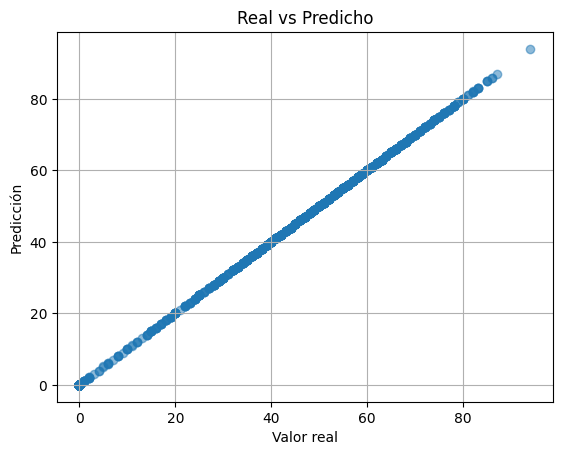

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Value")
plt.ylabel("Prediction")
plt.title("Actual vs Predicted")
plt.grid()
plt.show()

#### Saving the Final Model

In [ ]:
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)